# Stable diffusion

## Generative models

The goal of generative models is to generate new images that are similar, in other words, "representive" of our original set of images. To do this, they have to learn the probability density function $p(x)$. This probability density effectively describes the behaviour of our training data and enables us to generate novel data by sampling from the distribution. Ideally, we want our model to learn a probability $p(x)$ density which will be identical to the density of our data $p_{data}(x)$. Towards that goal, there are many different strategies.

The first class of models is able to actually compute the density function $p$ explicitly. This means that after training, we can feed a data point $x$ to the model and it will output the likelihood of the data point, which of course is the result of $p(x)$. Explicit density models can either compute exactly the density function or try to approximate it. Variational autoencoders fall in the latter category. We often refer to them as Latent Variable models.

The second class, known as implicit density models, does not compute $p(x)$. However, we are able to sample from the underlying distribution after the model is trained. Implicit density models are able to map the underlying distribution without computing it explicitly. They are mainly represented by Generative Adversarial Networks (GANs).

During a single training epoch for a single training sample with a GAN, for example, a noise vector gets passed to a generator network that outputs an image of what we want to produce. Then we have to determine if the generator did a good job. To do that, we pass the image to the discriminator network, which determines if the image is real or fake.

This works, but GANs often run into problems like mode collapse where the generator collapses onto generating only a single image that it can continuously fool the discriminator with. Intuitively, it's a hard problem to go from a random noise vector to a great looking, quality resolution, realistic image in one step.

With diffusion models, we simplify the process into small, iterative steps so that the work that the generative model has to do at each step is much less. In other words, in a single training epoch, we break up the problem from one step into several small steps. The intuition behind this is that the model can correct itself over small steps and gradually produce a good sample.

There are already a bunch of different diffusion-based architectures. We will focus on the most prominent one, which is the Denoising Diffusion Probabilistic Models (DDPM) as initialized by [Sohl-Dickstein](https://arxiv.org/abs/1503.03585) and then proposed by [Ho](https://arxiv.org/abs/2006.11239).

## Diffusion process

The basic idea behind diffusion models is rather simple. They take the input image $x_0$ and gradually add Gaussian noise to it through a series of $T$ steps. We call this the forward process.

Afterward, a neural network is trained to recover the original data by reversing the noising process. By being able to model the reverse process, we can generate new data. The is the so-called reverse diffusion process or, in general, the sampling process of a generative model.

### Forward diffusion

In the forward diffusion process, we slowly and iteratively add noise to corrupt the images in our training set such that they move away from their existing subspace. What we are doing here is converting the unknown and complex distribution that our training set belongs to into one that is easy for us to sample a data point from and understand. 

In practice, the diffusion models are formulated using a Markov chain of $T$ steps. Here, a Markov chain means that each step only depends on the previous one, which is a mild assumption. 
Specifically, at each step of the Markov chain we add Gaussian noise with variance $\beta_t$ to $x_{t-1}$, producing a new latent variable $x_t$ with distribution $q(x_t|x_{t-1})$.

This diffusion process can be formulated as follows: $q(x_t|x_{t-1} = \mathcal{N}(x_t;\mu_t = \sqrt{1 - \beta_t}x_{t-1}, \Sigma_t = \beta_tI)$
Since we are in the multi-dimensional scenario **I** is the identity matrix, indicating each dimension has the same standard deviation $\beta_t$. Note that $q(x_t|x_{t-1})$ is still a normal distribution, defined by the mean $\mu$ and the variance $\Sigma$ where $\mu_t = \sqrt{1 - \beta_t}x_{t-1}$ and $\Sigma_t = \beta_tI$.

Thus, we can go in a closed form from the input data $x_0$ to $x_T$ in a tractable way. Mathematically, this is the posterior probability and is defined as:
$q(x_{1:T}|x_0) = \prod\limits_{t=1}^{T}q(x_t|x_{t-1})$.
So far, so good? Well, nah! For timestep $t = 500 < T$ we need to apply $q$ 500 times in order to sample $x_t$.
The [reparametrization trick](./102_reparametrization.ipynb) provides a magic remedy to this.

If we define $\alpha_t = 1 - \beta_t$, $\overline{\alpha}_t = \prod\limits_{s=0}^{t}\alpha_s$, we can use the reparameterization trick in a recursive manner to prove that:

$$x_t = \sqrt{1 - \beta_t}x_{t-1} + \sqrt{\beta_t}\epsilon_{t-1}$$
$$x_t = \sqrt{\alpha_t\alpha_{t-1}}x_{t-2} + \sqrt{1 - \alpha_t\alpha_{t-1}}\overline{\epsilon}_{t-2}$$
$$x_t = ... $$
$$x_t = \sqrt{\overline{\alpha}_t}x_0 + \sqrt{1 - \overline{\alpha}_t}\epsilon$$

Since $\beta_t$ is a hyperparameter, we can precompute $\alpha_t$ and $\overline{\alpha}_t$ for all timesteps. This means that we sample noise at any timestep $t$ and get $x_t$ in one go.

### Varaince schedule

The variance parameter $\beta_t$ can be fixed to a constant or chosen as a schedule over the $T$ timesteps. In fact, one can define a variance schedule, which can be linear, quadratic, cosine etc. The original DDPM authors utilized a linear schedule increasing from $\beta_1 = 10^{-1}$ to $\beta_T = 0.02$. [Nichol](https://arxiv.org/abs/2102.09672) showed that employing a cosine schedule works even better.

![Screenshot 2024-01-11 at 21.30.03.png](<attachment:Screenshot 2024-01-11 at 21.30.03.png>)
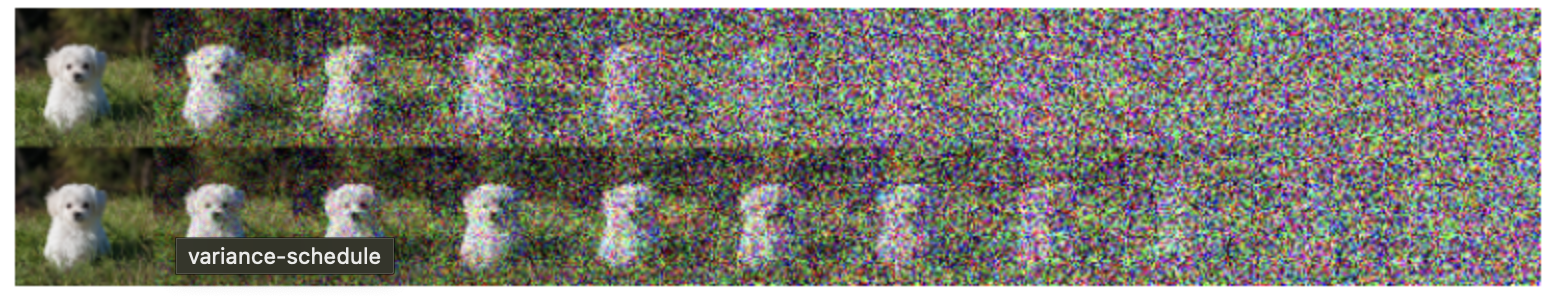

## Reverse diffusion process

In the reverse diffusion process, the idea is to reverse the forward process. We slowly and iteratively try to reverse the corruption performed on images in the forward process.
The benefit of starting from a simple space is that we know how to sample a point from this distribution.
The goal here is to figure out how to return to the data subspace.

![Screenshot 2024-01-17 at 16.37.59.png](<attachment:Screenshot 2024-01-17 at 16.37.59.png>)

As $T \rightarrow \infty$, the latent $x_T$ is nearly an isotropic Gaussian distribution. Therefore if we manage to learn the reverse distribution $p(x_{t-1}|x_t)$, we can sample $x_T$ from $\mathcal{N}(0,I)$, run the reverse process and acquire a sample from $p(x_0)$, generating a novel data point from the original data distribution.
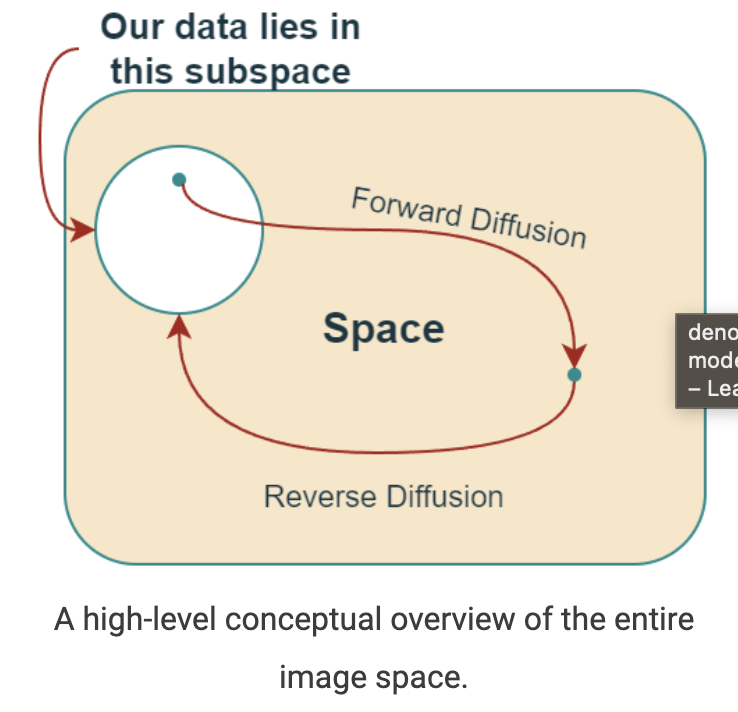

### Approximating the reverse process with a neural network

In practical terms, we don't know $p(x_{t-1}|x_t)$. It's intractable since statistical estimates require computations involving the data distribution.

Instead, we approximate $p(x_{t-1}|x_t)$ with a parameterized model $p_\theta$ (e.g. a neural network). Since $p(x_{t-1}|x_t)$ will also be Gaussian, for small enough $\beta_t$, we can choose $p_\theta$ to be Gaussian and just parameterize the mean and variance:$$p_\theta(x_{t-1}|x_t) = \mathcal{N}(x_{t-1};\mu_{\theta}(x_t,t), \Sigma_\theta(x_t,t))$$
If we apply the reverse formula for all timesteps, also called trajectory, we can go from $x_T$ to the data distribution: $$p_\theta(x_{0:T}) = p_\theta(x_T) \prod\limits_{t=1}^{T}p_\theta(x_{t-1}|x_t))$$

By additionally conditioning the model on timestep t, it will learn to predict the Gaussian parameters (meaning the mean $\mu_\theta(x_t,t)$ and the covariance matrix $\Sigma_\theta(x_t,t))$) for each timestep. 

### Training a diffusion model

If we take a step back, we can notice that the combination of $q$ and $p$ is very similar to a [variational autoencoder (VAE)](./103_vae.ipynb).

Thus, we can train it by optimizing the negative log-likelihood of the training data. After a series of calculations we can write the evicence lower bound (ELBO) as follows.
$$log p(x) \ge E_q(x_1|x_0)[log p_\theta(x_0|x_1)] - $$
$$D_{KL}(y(x_T|x_0)||p(x_T))-$$
$$\sum_{t=2}^T{E_q(x_t|x_0)[D_{KL}(q(x_{t-1}|x_t,x_0)||p_\theta(x_{t-1}|x_t))]}$$
$$= L_0 - L_T - \sum_{t=2}^{T}{L_{t-1}}$$

Let's analyze these terms:
1. The $E_q(x_1|x_0)[log p_\theta(x_0|x_1)]$ term can been as a reconstruction term, similar to the one in a variational autoencoder. In [Ho](https://arxiv.org/abs/2006.11239), this term is learned using a separate decoder.
2. $D_{KL}(q(x_T|x_0)||p(x_T))$ shows how close $x_T$ is to the standard Gaussian. Note that the entire term has no trainable parameters so we can't do anything about it except define a good variance scheduler and use large timesteps such that they both represent an Isotropic Gaussian distribution.
3. The third term $\sum_{t=2}^{T}{L_{t-1}}$, also referred al $L_t$ formulate the difference between the desired denoising steps $p_\theta(x_{t-1}|x_t)$ and the approximated ones $q(x_{t-1}|x_t,x_0)$.

It is evident that through the ELBO, maximizing the likelihood boils down to learning the denoising steps $L_t$.

> Even though $q(x_{t-1}|x_t)$ is intractable, [Sohl-Dickstein](https://arxiv.org/abs/1503.03585) illustrated that by additionally conditioning on $x_0$ makes it tractable.

Intuitively, a painter needs a reference image ($x_0$) to slowly draw an image. Thus, we can take a small step backwards, meaning from noise to generate an image, if and only if we have $x_0$ as a reference.

In other words, we can sample $x_t$ at noise level $t$ conditioned on $x_0$. Since $\alpha_t = 1 - \beta_t$ and $\overline{\alpha}_t = \prod\limits_{s=0}^{t}\alpha_s$, we can prove that:
$$q(x_{t-1}|x_t,x_0) = \mathcal{N}(x_{t-1};\mu(x_t,x_0), \overline{\beta}_tI)$$
$$
\overline{\beta}_t = \frac{1 - \overline{\alpha}_{t-1}}{1 - \overline{\alpha}_t}\beta_t$$
$$\overline{\mu}_t(x_t,x_0) = \frac{\sqrt{\overline{\alpha}_{t-1}}\beta_t}{1 - \overline{\alpha}_t}x_0 + \frac{\sqrt{\alpha_t}(1 - \overline{\alpha}_{t-1})}{1 - \overline{\alpha}_t}x_t$$

This little trick provides us with a fully tractable ELBO. The above property has one more important side effect, as we already saw in the reparameterization trick, we can represent $x_0$ as $$x_0 = \frac{1}{\sqrt{\overline{\alpha}_t}}(x_t - \sqrt{1 - \overline{\alpha}_t\epsilon})$$ where $\epsilon \sim \mathcal{N}(0,I)$.

By combining the last two equations, each timestep will now have a mean $\overline{\mu}_t$ (our target) that only depends on $x_t$:
$$\overline{\mu}_t(x_t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1 - \overline{\alpha}_t}}\epsilon) $$

Therefore we can use a neural network to approximate $\epsilon$ and consequently the mean: $$\overline{\mu_\theta}(x_t,t) = \frac{1}{\sqrt{\alpha_t}}(x_t - \frac{\beta_t}{\sqrt{1 - \overline{\alpha}_t}}\epsilon_\theta(x_t,t)) $$

Thus, the loss function (the denoising term in the ELBO) can be expressed as:
$$L_t = E_{x_0,t,\epsilon}[\frac{1}{2||\Sigma_\theta(x_t,t)||_2^2}||\overline{\mu_t} - \mu_\theta(x_t,t)||_2^2] $$
$$= E_{x_0,t,\epsilon}[\frac{\beta_t^2}{2\alpha_t(1-\overline{\alpha}_t)||\Sigma_\theta||_2^2}||\epsilon_t - \epsilon_\theta(\sqrt{\overline{\alpha}_t}x_0 + \sqrt{1 - \overline{\alpha}_t}\epsilon,t)||^2]$$

This effectively shows us that instead of predicting the mean of the distribution, the model will predict the noise $\epsilon$ at each timestep $t$.

The authors found that optimizing the above objective works better than optimizing the original ELBO. The proof for both equations can be found in this [excellent post by Lillian Weng](https://lilianweng.github.io/posts/2021-07-11-diffusion-models/#reverse-diffusion-process) or in [Luo](https://arxiv.org/abs/2208.11970).

Additionally, [Ho](https://arxiv.org/abs/2006.11239) decided to keep the variance fixed and have the network learn only the mean. This was later improved by [Nichol](https://arxiv.org/abs/2102.09672), who decide to let the network learn the covariance matrix as well, achieving better results.